In [1]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
base_dataset = pd.read_csv("covid_without_NA.csv")
imb_dataset = pd.read_csv("imbalanced_data.csv")
imputed_dataset = pd.read_csv("imputed_dataset.csv")
db_dataset = pd.read_csv("imputed_oversampled_dataset.csv")


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y = None):
        return self.fit(X,y).transform(X)

In [3]:
# X and Y matrix for base dataset
X_base = base_dataset.drop([
    "Unnamed: 0",
    "to_patient_id", "last.status"
], axis = 1)
X_base['temperature.over38'] = X_base['temperature.over38'].astype(float).astype(object)
X_base['pulseOx.under90'] = X_base['pulseOx.under90'].astype(float).astype(object)
X_base['Respiration.over24'] = X_base['Respiration.over24'].astype(float).astype(object)
Y_base = base_dataset[["last.status"]]

In [4]:
X_base_cate = MultiColumnLabelEncoder().fit_transform(
    X_base.drop(['invasive_vent_days',
                    'length_of_stay',
                    'days_prior_sx'
                   ]
                    ,axis = 1))
Y_base_cate = MultiColumnLabelEncoder().fit_transform(
    Y_base)

In [5]:
X_base_df = pd.concat([
    X_base_cate,
    X_base[['invasive_vent_days']],
    X_base[['length_of_stay']],
    X_base[['days_prior_sx']]],
    axis = 1
)

In [6]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base_df, 
    Y_base_cate, 
    test_size = 0.1, 
    random_state = 42)

In [7]:
model_base = Ridge(alpha=1.0)
model_base.fit(X_base_df, np.ravel(Y_base_cate))

Ridge()

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


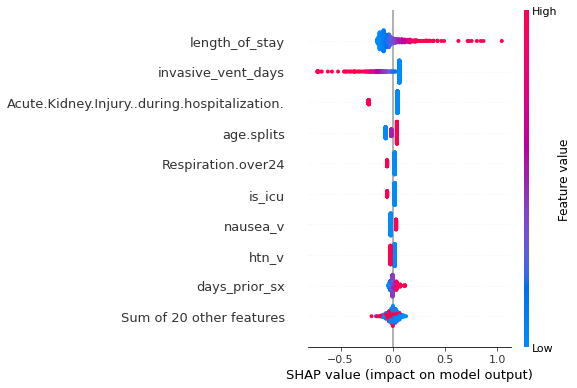

In [8]:
explainer_base = shap.LinearExplainer(model_base, X_base_df, feature_perturbation="interventional")
shap_values_base = explainer_base(X_base_df)
shap_pic1_base = shap.plots.beeswarm(shap_values_base, show = False)
plt.tight_layout()
plt.savefig('823_project/draft_pic/shap_pic1_base.png')

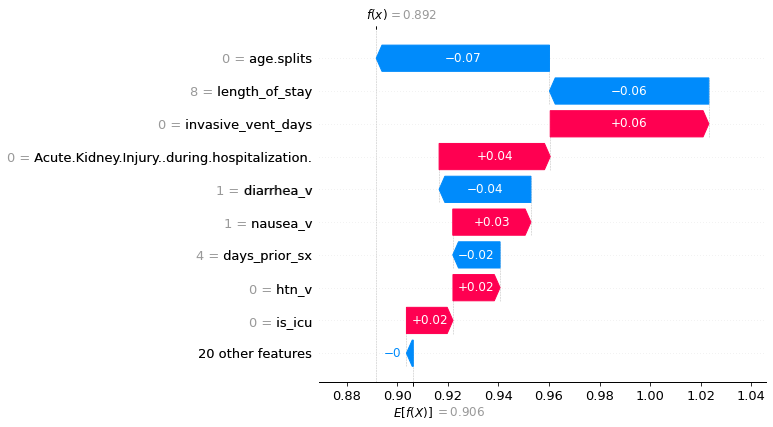

In [9]:
shap.plots.waterfall(shap_values_base[0])

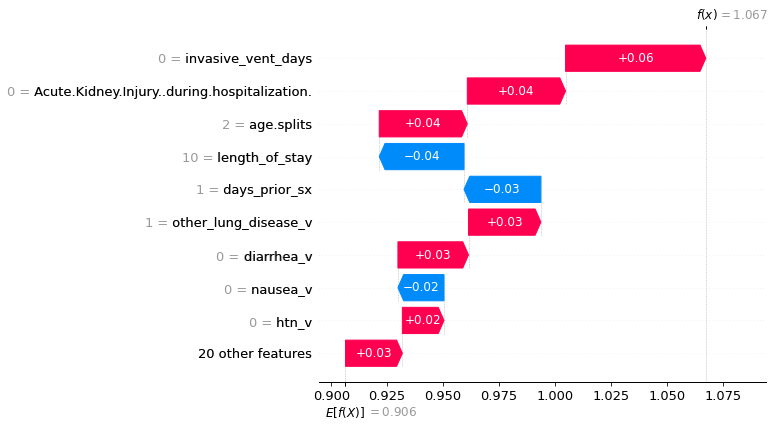

In [10]:
shap.plots.waterfall(shap_values_base[3])

In [11]:
df_age = imb_dataset[["age.splits_(59,74]",
                      "age.splits_(74,90]",
                      "age.splits_[18,59]"]]
df_age = df_age.idxmax(axis = 1)
age = df_age.str.split('_').str[1]

df_gender = imb_dataset[["gender_concept_name_FEMALE",
                         "gender_concept_name_MALE"]]
df_gender = df_gender.idxmax(axis = 1)
gender = df_gender.str.split('_').str[3]

df_visit = imb_dataset[["visit_concept_name_Emergency Room Visit",
                              "visit_concept_name_Inpatient Visit"]]
df_visit = df_visit.idxmax(axis = 1)
visit = df_visit.str.split('_').str[3]

df_acute_hep = imb_dataset[["Acute.Hepatic.Injury..during.hospitalization._No",
                                  "Acute.Hepatic.Injury..during.hospitalization._Yes"]]
df_acute_hep = df_acute_hep.idxmax(axis = 1)
acute_hep = df_acute_hep.str.split('_').str[1]

df_acute_kid = imb_dataset[["Acute.Kidney.Injury..during.hospitalization._No",
                                  "Acute.Kidney.Injury..during.hospitalization._Yes"]]
df_acute_kid = df_acute_kid.idxmax(axis = 1)
acute_kid = df_acute_kid.str.split('_').str[1]

df_htn = imb_dataset[["htn_v_No",
                            "htn_v_Yes"]]
df_htn = df_htn.idxmax(axis = 1)
htn = df_htn.str.split('_').str[2]

df_dm = imb_dataset[["dm_v_No",
                           "dm_v_Yes"]]
df_dm = df_dm.idxmax(axis = 1)
dm = df_dm.str.split('_').str[2]

df_cad = imb_dataset[["cad_v_No",
                           "cad_v_Yes"]]
df_cad = df_cad.idxmax(axis = 1)
cad = df_cad.str.split('_').str[2]

df_ckd = imb_dataset[["ckd_v_No",
                           "ckd_v_Yes"]]
df_ckd = df_ckd.idxmax(axis = 1)
ckd = df_ckd.str.split('_').str[2]

df_malign = imb_dataset[["malignancies_v_No",
                           "malignancies_v_Yes"]]
df_malign = df_malign.idxmax(axis = 1)
malign = df_malign.str.split('_').str[2]

df_copd = imb_dataset[["copd_v_No",
                           "copd_v_Yes"]]
df_copd = df_copd.idxmax(axis = 1)
copd = df_copd.str.split('_').str[2]

df_other_lung = imb_dataset[["other_lung_disease_v_No",
                           "other_lung_disease_v_Yes"]]
df_other_lung = df_other_lung.idxmax(axis = 1)
other_lung = df_other_lung.str.split('_').str[4]

df_anti = imb_dataset[["antibiotics_use_v_No",
                           "antibiotics_use_v_Yes"]]
df_anti = df_anti.idxmax(axis = 1)
anti = df_anti.str.split('_').str[3]

df_smoking = imb_dataset[["smoking_status_v_Current",
                                "smoking_status_v_Former",
                                "smoking_status_v_Never"]]
df_smoking = df_smoking.idxmax(axis = 1)
smoking = df_smoking.str.split('_').str[3]

df_cough = imb_dataset[["cough_v_No",
                              "cough_v_Yes"]]
df_cough = df_cough.idxmax(axis = 1)
cough = df_cough.str.split('_').str[2]

df_dyspnea = imb_dataset[["dyspnea_admission_v_No",
                              "dyspnea_admission_v_Yes"]]
df_dyspnea = df_dyspnea.idxmax(axis = 1)
dyspnea = df_dyspnea.str.split('_').str[3]

df_nausea = imb_dataset[["nausea_v_No",
                              "nausea_v_Yes"]]
df_nausea = df_nausea.idxmax(axis = 1)
nausea = df_nausea.str.split('_').str[2]

df_vomit = imb_dataset[["vomiting_v_No",
                              "vomiting_v_Yes"]]
df_vomit = df_vomit.idxmax(axis = 1)
vomit = df_vomit.str.split('_').str[2]



In [12]:
df_diarrhea = imb_dataset[["diarrhea_v_No",
                              "diarrhea_v_Yes"]]
df_diarrhea = df_diarrhea.idxmax(axis = 1)
diarrhea = df_diarrhea.str.split('_').str[2]

df_pain = imb_dataset[["abdominal_pain_v_No",
                                 "abdominal_pain_v_Yes"]]
df_pain = df_pain.idxmax(axis = 1)
pain = df_pain.str.split('_').str[3]

df_fever = imb_dataset[["fever_v_No",
                              "fever_v_Yes"]]
df_fever = df_fever.idxmax(axis = 1)
fever = df_fever.str.split('_').str[2]


df_bmi = imb_dataset[["BMI_Above 35",
                             "BMI_Between 30 and 35",
                            "BMI_Under 30"]]
df_bmi = df_bmi.idxmax(axis = 1)
bmi = df_bmi.str.split('_').str[1]

In [13]:
x_input = {
    "is.icu": imb_dataset["is_icu"],
    "invasive_vent_days": imb_dataset["invasive_vent_days"],
    "length_of_stay": imb_dataset["length_of_stay"],
    "days_prior_sx": imb_dataset["days_prior_sx"],
    "temperature.over38": imb_dataset["temperature.over38"],
    "pulseOx.under90": imb_dataset["pulseOx.under90"],
    "Respiration.over24": imb_dataset["Respiration.over24"],
    "age.splits": age,
    "gender_concept_name": gender,
    "visit_concept_name": visit,
    "Acute.Hepatic.Injury..during.hospitalization.": acute_hep,
    "Acute.Kidney.Injury..during.hospitalization.": acute_kid,
    "htn_v": htn,
    "dm_v": dm,
    "cad_v": cad,
    "ckd_v": ckd,
    "malignancies_v": malign,
    "copd_v": copd,
    "other_lung_disease_v": other_lung,
    "antibiotics_use_v": anti,
    "smoking_status_v": smoking,
    "cough_v": cough,
    "dyspnea_admission_v": dyspnea,
    "nausea_v": nausea,
    "vomiting_v": vomit,
    "diarrhea_v": diarrhea,
    "abdominal_pain_v": pain,
    "fever_v": fever,
    "BMI": bmi
}
X_imbalance = pd.DataFrame(x_input)

In [14]:
# X and Y matrix for imbalance dataset
X_imbalance['temperature.over38'] = X_imbalance['temperature.over38'].astype(float).astype(object)
X_imbalance['pulseOx.under90'] = X_imbalance['pulseOx.under90'].astype(float).astype(object)
X_imbalance['Respiration.over24'] = X_imbalance['Respiration.over24'].astype(float).astype(object)
Y_imbalance = imb_dataset[["last_status"]]

In [15]:
X_imbalance_cate = MultiColumnLabelEncoder().fit_transform(
    X_imbalance.drop(['invasive_vent_days',
                    'length_of_stay',
                    'days_prior_sx'
                   ]
                    ,axis = 1))
Y_imbalance_cate = MultiColumnLabelEncoder().fit_transform(
    Y_imbalance)

In [16]:
X_imbalance_df = pd.concat([
    X_imbalance_cate,
    X_imbalance[['invasive_vent_days']],
    X_imbalance[['length_of_stay']],
    X_imbalance[['days_prior_sx']]],
    axis = 1
)

In [17]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imbalance_df, 
                                                                Y_imbalance_cate, 
                                                                test_size = 0.1, 
                                                                random_state = 42)

In [18]:
model_imb = CatBoostClassifier(iterations = 2,
                               depth = 2,
                               learning_rate = 1,
                               loss_function = 'Logloss',
                               verbose = True)
model_imb.fit(X_imbalance_df, np.ravel(Y_imbalance_cate))

0:	learn: 0.3254063	total: 52.5ms	remaining: 52.5ms
1:	learn: 0.2685926	total: 54ms	remaining: 0us


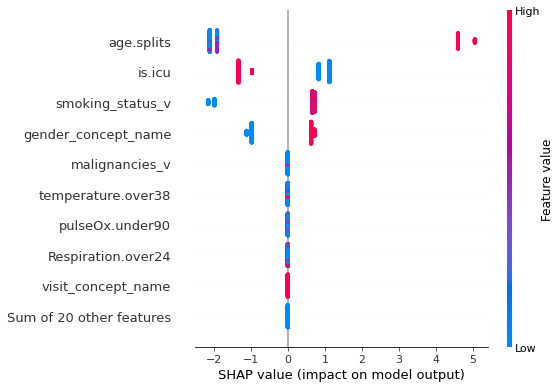

In [19]:
explainer_imb = shap.TreeExplainer(model_imb, X_imbalance_df, feature_perturbation="interventional")
shap_values_imb = explainer_imb(X_imbalance_df)
shap_pic1_imb = shap.plots.beeswarm(shap_values_imb, show = False)
plt.tight_layout()
plt.savefig('823_project/draft_pic/shap_pic1_imb.png')

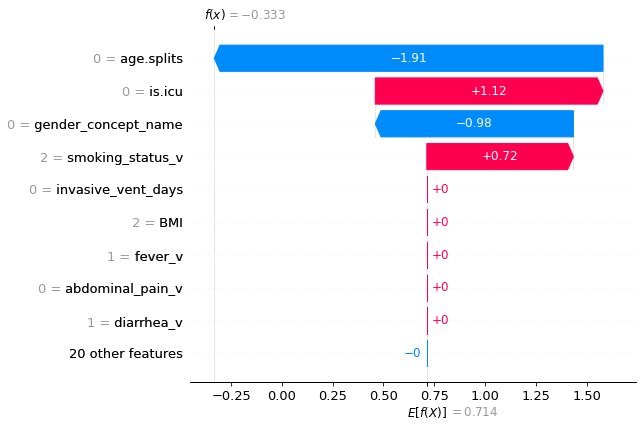

In [20]:
shap.plots.waterfall(shap_values_imb[0])

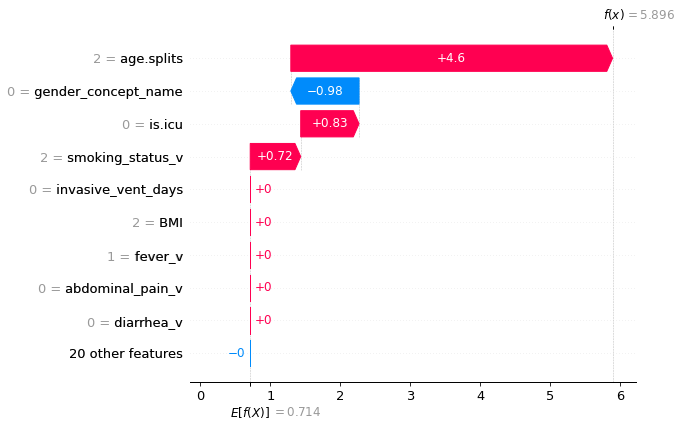

In [21]:
shap.plots.waterfall(shap_values_imb[3])

In [22]:
# X and Y matrix for imputed dataset
X_imputed = imputed_dataset.drop([
    "Unnamed: 0", "last.status"
], axis = 1)
X_imputed['temperature.over38'] = X_imputed['temperature.over38'].astype(float).astype(object)
X_imputed['pulseOx.under90'] = X_imputed['pulseOx.under90'].astype(float).astype(object)
X_imputed['Respiration.over24'] = X_imputed['Respiration.over24'].astype(float).astype(object)
Y_imputed = imputed_dataset[["last.status"]]

In [23]:
X_imputed_cate = MultiColumnLabelEncoder().fit_transform(
    X_imputed.drop(['invasive_vent_days',
                    'length_of_stay',
                    'days_prior_sx'
                   ]
                    ,axis = 1))

In [24]:
X_imputed_df = pd.concat([
    X_imputed_cate,
    X_imputed[['invasive_vent_days']],
    X_imputed[['length_of_stay']],
    X_imputed[['days_prior_sx']]],
    axis = 1
)

In [25]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X_imputed_df, 
                                                                Y_imputed, 
                                                                test_size = 0.1, 
                                                                random_state = 42)

In [26]:
model_im = LogisticRegression(penalty = "l2", C = 0.1)
model_im.fit(X_imputed_df, np.ravel(Y_imputed))

LogisticRegression(C=0.1)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


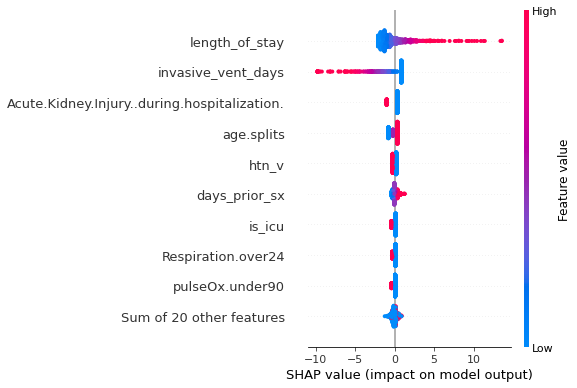

In [27]:
explainer_im = shap.LinearExplainer(model_im, X_imputed_df, feature_perturbation="interventional")
shap_values_im = explainer_im(X_imputed_df)
shap_pic1_im = shap.plots.beeswarm(shap_values_im, show = False)
plt.tight_layout()
plt.savefig('823_project/draft_pic/shap_pic1_im.png')

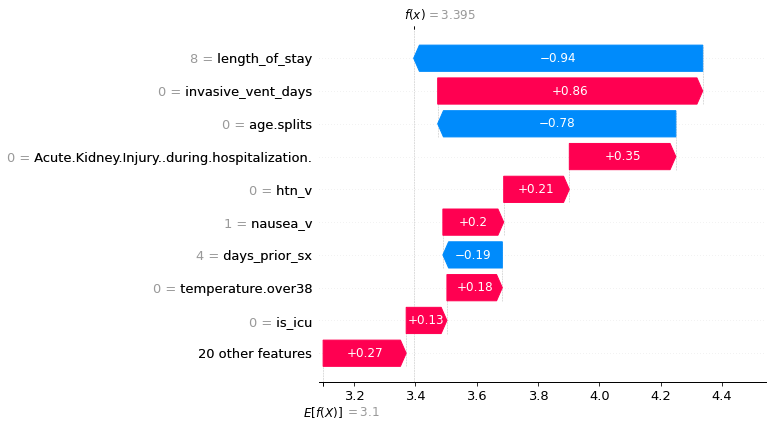

In [28]:
shap.plots.waterfall(shap_values_im[0])

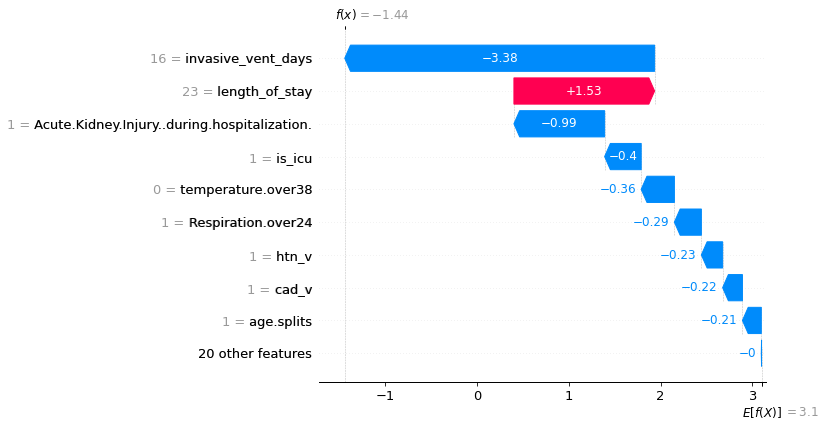

In [29]:
shap.plots.waterfall(shap_values_im[2])

In [30]:
# X and Y matrix for both imputed and over-sampling dataset
X_db = db_dataset.drop([
    "Unnamed: 0", "last.status"
], axis = 1)
X_db['temperature.over38'] = X_db['temperature.over38'].astype(float).astype(object)
X_db['pulseOx.under90'] = X_imputed['pulseOx.under90'].astype(float).astype(object)
X_db['Respiration.over24'] = X_db['Respiration.over24'].astype(float).astype(object)
Y_db = db_dataset[["last.status"]]

In [31]:
X_db_cate = MultiColumnLabelEncoder().fit_transform(
    X_db.drop(['invasive_vent_days',
                    'length_of_stay',
                    'days_prior_sx'
                   ]
                    ,axis = 1))

In [32]:
X_db_df = pd.concat([
    X_db_cate,
    X_db[['invasive_vent_days']],
    X_db[['length_of_stay']],
    X_db[['days_prior_sx']]],
    axis = 1
)

In [33]:
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(X_db_df, 
                                                                Y_db, 
                                                                test_size = 0.1, 
                                                                random_state = 42)

In [34]:
model_db = LogisticRegression(penalty = "l2", C = 0.1,
                             max_iter = 200)
model_db.fit(X_db_df, np.ravel(Y_db))

LogisticRegression(C=0.1, max_iter=200)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


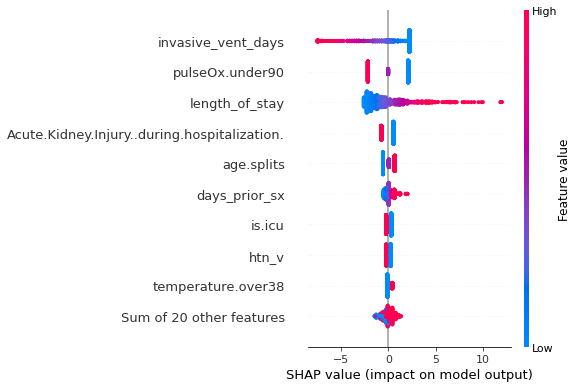

In [35]:
explainer_db = shap.LinearExplainer(model_db, X_db_df, 
                                    feature_perturbation = "interventional")
shap_values_db = explainer_db(X_db_df)
shap_pic1_db = shap.plots.beeswarm(shap_values_db, show = False)
plt.tight_layout()
plt.savefig('823_project/draft_pic/shap_pic1_db.png')

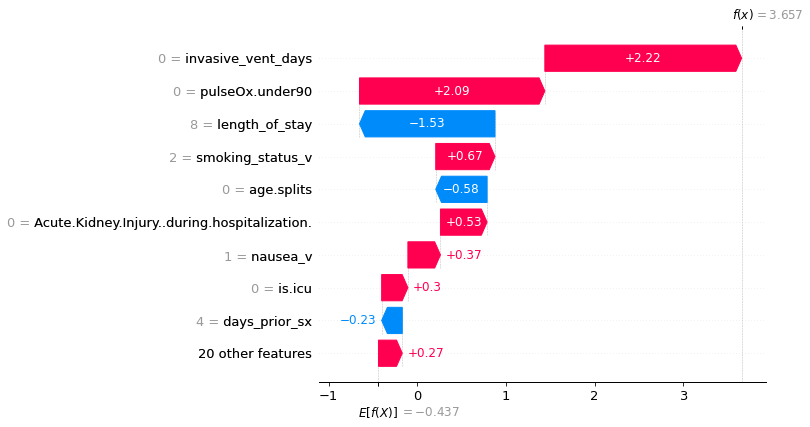

In [36]:
shap_pic2_db = shap.plots.waterfall(shap_values_db[0])

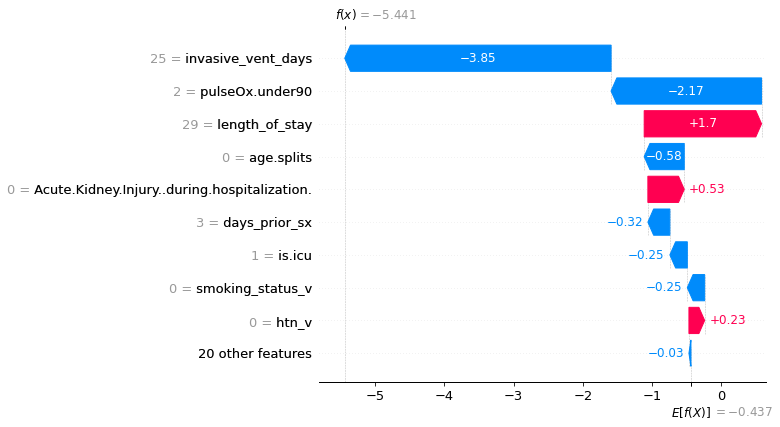

In [37]:
shap.plots.waterfall(shap_values_db[1000])

In [38]:
shap_values50 = explainer_db.shap_values(X_db_df.iloc[280:300,:])

In [39]:
shap.initjs()
shap_pic2_db = shap.force_plot(explainer_db.expected_value, shap_values50,
                               X_db_df.iloc[280:300,:],
                               show = False)
shap_pic2_db